# Baseline training

This script trains a baseline model based on the generated data from script 1.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

In [2]:
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from agent import RecommendationAgent
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
agent = RecommendationAgent(n_statistics=7, alpha=0.1, decay_rate=0.95, epsilon=0.1)

agent.add_domain('general')

agent.add_visualization('nodelink topology driven')
agent.add_visualization('nodelink attribute driven faceting')
agent.add_visualization('nodelink attribute driven positioning')
agent.add_visualization('adjacency matrix')
agent.add_visualization('quilts')
agent.add_visualization('biofabric')
agent.add_visualization('treemap')
agent.add_visualization('sunburst')

In [4]:
with open('../data/training.json', 'r') as file:
    training = json.load(file)

with open('../data/testing.json', 'r') as file:
    testing = json.load(file)

In [5]:
test_interval = 500
accuracies = []
precisions = []
recalls = []
f1_scores = []
intervals = []
q_values_over_time = []
chosen_actions_over_time = []

for i, sample in enumerate(training[:10000]):
    domain = sample['domain']
    statistics = sample['statistics']
    prediction = sample['visualization']
    state_id = agent.state_id(statistics)
    action, require_feedback = agent.recommend_visualization(domain, state_id)
    recommendation_index = agent.visualizations.index(prediction)
    agent.update_q_value(domain, state_id, recommendation_index, reward=5, require_feedback=True)

    if (i + 1) % test_interval == 0:
        agent_epsilon = agent.epsilon
        agent.epsilon = 0
        test_samples = random.sample(testing, 300)

        y_true = []
        y_pred = []
        
        for test_sample in test_samples:
            test_domain = test_sample['domain']
            test_statistics = test_sample['statistics']
            label = test_sample['visualization']
            test_state_id = agent.state_id(test_statistics)
            test_recommended_index, _ = agent.recommend_visualization(test_domain, test_state_id)
            y_true.append(agent.visualizations.index(label))
            y_pred.append(test_recommended_index)
        
        accuracy = sum(1 for x, y in zip(y_true, y_pred) if x == y) / len(test_samples)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=True)
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        intervals.append(i + 1)

        if i == 0:
            tracked_state_id = state_id
            q_values_over_time.append(agent.scores[domain][agent.format_state_id(tracked_state_id)].copy())
            chosen_actions_over_time.append(action)
        
        agent.epsilon = agent_epsilon

        print(f'Round: {i+1}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')


Round: 500, Accuracy: 0.68, Precision: 0.65, Recall: 0.68, F1 Score: 0.59
Round: 1000, Accuracy: 0.66, Precision: 0.65, Recall: 0.66, F1 Score: 0.60
Round: 1500, Accuracy: 0.61, Precision: 0.60, Recall: 0.61, F1 Score: 0.56
Round: 2000, Accuracy: 0.66, Precision: 0.66, Recall: 0.66, F1 Score: 0.62


/Users/sjoerdvink/Developer/visualization-recommendation/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round: 2500, Accuracy: 0.65, Precision: 0.64, Recall: 0.65, F1 Score: 0.61


/Users/sjoerdvink/Developer/visualization-recommendation/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round: 3000, Accuracy: 0.64, Precision: 0.64, Recall: 0.64, F1 Score: 0.60
Round: 3500, Accuracy: 0.79, Precision: 0.80, Recall: 0.79, F1 Score: 0.77
Round: 4000, Accuracy: 0.67, Precision: 0.68, Recall: 0.67, F1 Score: 0.62


/Users/sjoerdvink/Developer/visualization-recommendation/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round: 4500, Accuracy: 0.67, Precision: 0.70, Recall: 0.67, F1 Score: 0.62
Round: 5000, Accuracy: 0.68, Precision: 0.68, Recall: 0.68, F1 Score: 0.65


/Users/sjoerdvink/Developer/visualization-recommendation/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round: 5500, Accuracy: 0.73, Precision: 0.74, Recall: 0.73, F1 Score: 0.70


## Evaluating the results

In [29]:
random_guess_accuracy = 1/8

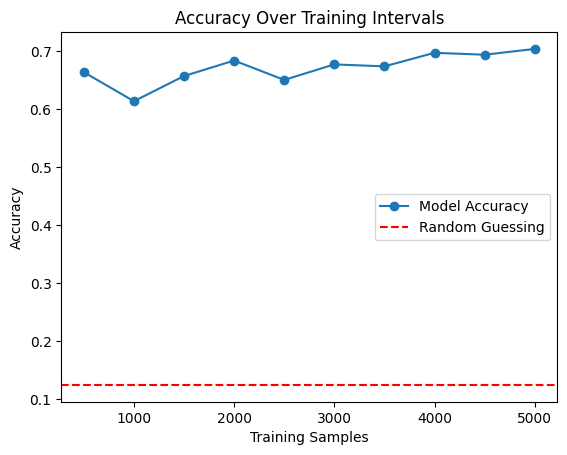

In [30]:
plt.plot(intervals, accuracies, marker='o', label='Model Accuracy')
plt.axhline(y=random_guess_accuracy, color='r', linestyle='--', label='Random Guessing')
plt.xlabel('Training Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Training Intervals')
plt.legend()
plt.show()

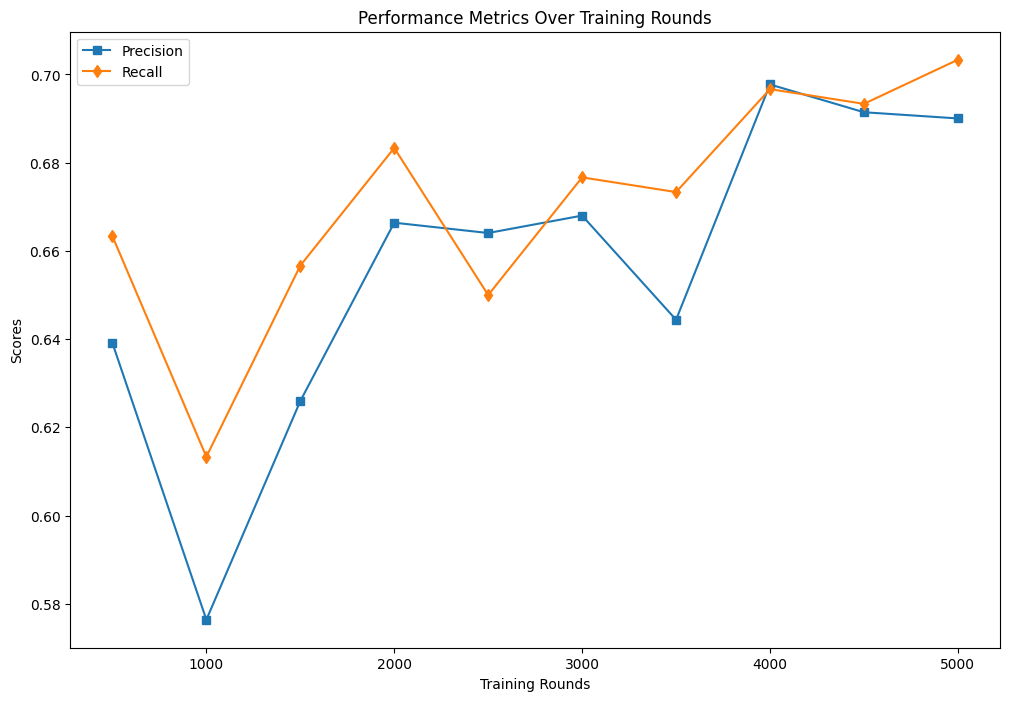

In [32]:
plt.figure(figsize=(12, 8))

plt.plot(intervals, precisions, label='Precision', marker='s')
plt.plot(intervals, recalls, label='Recall', marker='d')

plt.xlabel('Training Rounds')
plt.ylabel('Scores')
plt.title('Performance Metrics Over Training Rounds')
plt.legend()
plt.show()

## Decision boundaries

In [43]:
state_ids = []
labels = []

for key, value in agent.scores['general'].items():
    state_id = list(map(float, key.split(',')))
    label = agent.visualizations[np.argmax(value)]

    state_ids.append(state_id)
    labels.append(label)


state_ids = np.array(state_ids)
labels = np.array(labels)

pca = PCA(n_components=2)
state_ids_2d = pca.fit_transform(state_ids)

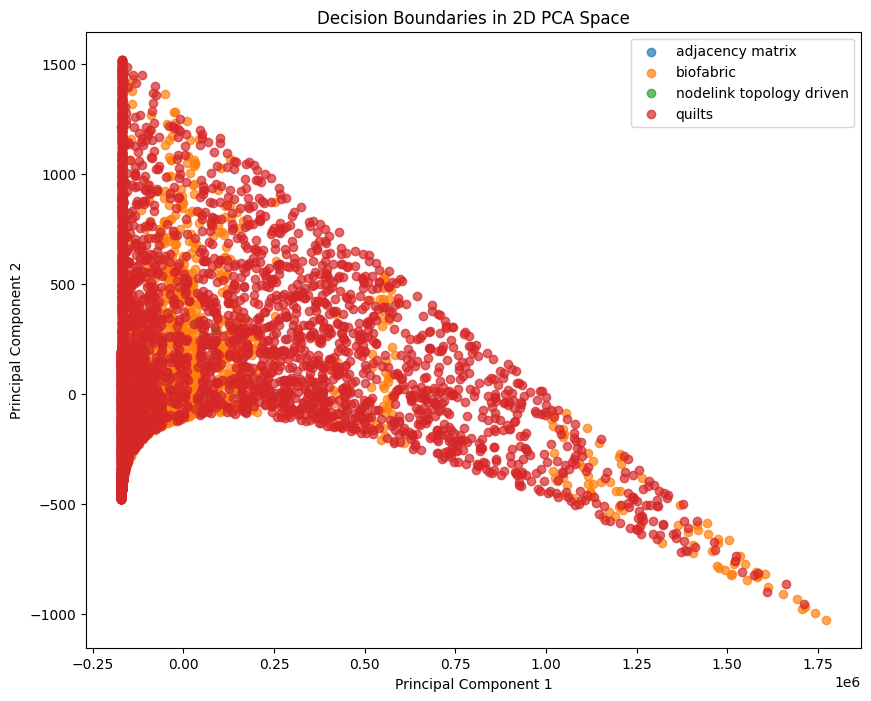

In [44]:
plt.figure(figsize=(10, 8))

unique_labels = np.unique(labels)
for label in unique_labels:
    mask = (labels == label)
    plt.scatter(state_ids_2d[mask, 0], state_ids_2d[mask, 1], label=label, alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundaries in 2D PCA Space')
plt.legend()
plt.show()

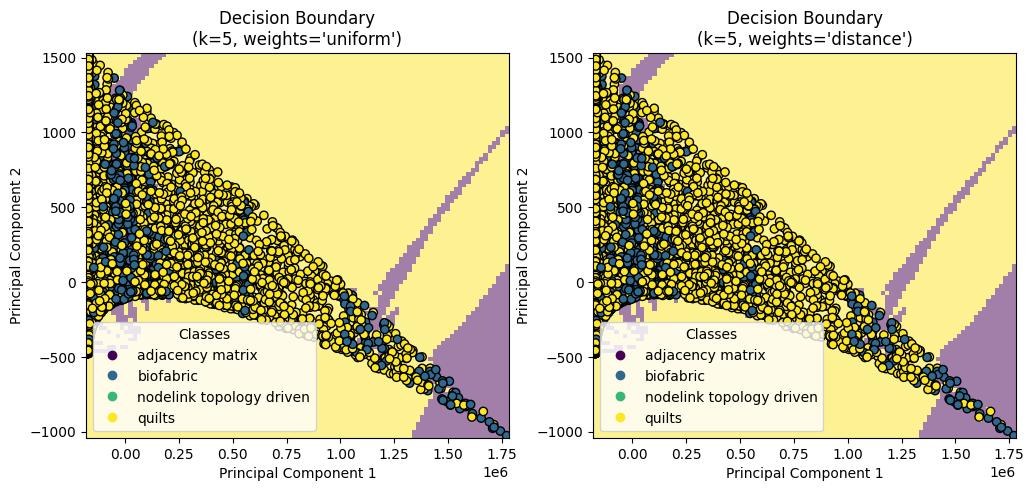

In [45]:
# Copied from: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay

# Encode the labels to numeric values
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Train a k-nearest neighbors classifier on the PCA-transformed data
clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5))]
)

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(state_ids_2d, numeric_labels)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        state_ids_2d,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel="Principal Component 1",
        ylabel="Principal Component 2",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(state_ids_2d[:, 0], state_ids_2d[:, 1], c=numeric_labels, edgecolors="k", cmap='viridis')
    unique_labels = label_encoder.classes_
    disp.ax_.legend(
        scatter.legend_elements()[0],
        unique_labels,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"Decision Boundary\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

# Feature importances

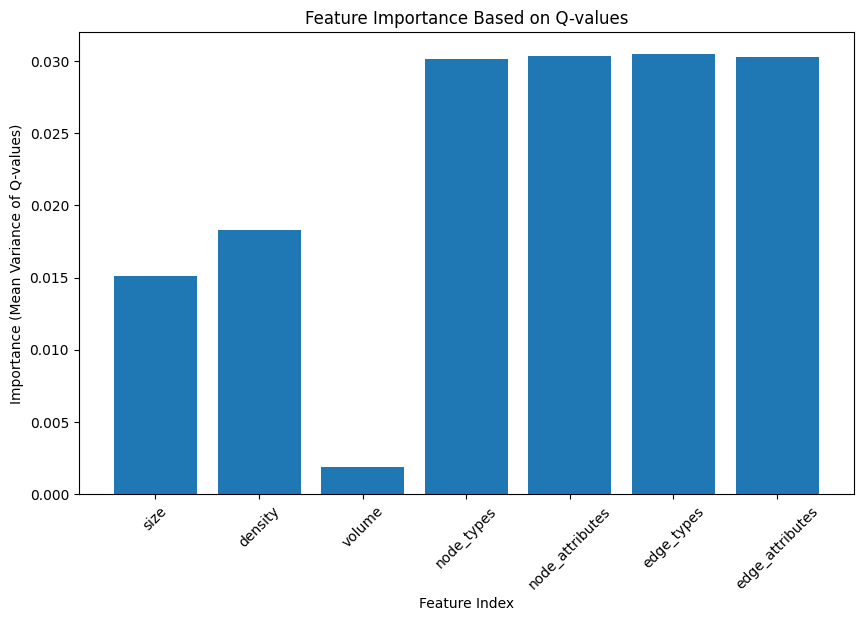

In [36]:
feature_names = [
    "size", "density", "volume", "node_types", "node_attributes", "edge_types", "edge_attributes"
]

# Extract state_ids and Q-values
state_ids = []
q_values = []

for key, value in agent.scores['general'].items():
    state_id = list(map(float, key.split(',')))
    q_value = value

    state_ids.append(state_id)
    q_values.append(q_value)

# Convert to numpy arrays
state_ids = np.array(state_ids)
q_values = np.array(q_values)

# Calculate feature importances
# Feature importance can be approximated by the variance of Q-values with respect to each feature in state_ids
n_features = state_ids.shape[1]
feature_importances = np.zeros(n_features)

for i in range(n_features):
    unique_values = np.unique(state_ids[:, i])
    feature_q_variance = []

    for val in unique_values:
        indices = np.where(state_ids[:, i] == val)
        q_subset = q_values[indices]
        q_variance = np.var(q_subset, axis=0).mean()
        feature_q_variance.append(q_variance)

    feature_importances[i] = np.mean(feature_q_variance)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance (Mean Variance of Q-values)')
plt.title('Feature Importance Based on Q-values')
plt.xticks(rotation=45)
plt.show()


# Comp

In [17]:
x_test = [list(sample['statistics'].values()) for sample in testing[:3000]]
y_test = [sample['visualization'] for sample in testing[:3000]]

x_train = [list(sample['statistics'].values()) for sample in training[:5000]]
y_train = [sample['visualization'] for sample in training[:5000]]

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)



In [20]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9996666666666667
